In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
from Bio import SeqIO
from multiprocessing import Pool
from functools import partial
from datetime import datetime

In [3]:
# SETTING
pixel_max = 254 #Customerization

# CHANNEL 0: BASE
base_color_stride = 70 #Customerization
offset_a_g = 40 #Customerization
offset_t_c = 30 #Customerization

# CHANNEL 1: BASE QUALITY
default_quality = 0
base_quality_cap = 40

# CHANNEL 2: MAPPING QUALITY
mapping_set_empty = 0 #Customerization
mapping_quality_cap = 60 #Customerization

# CHANNEL 3: ON POSITIVE STRAND
set_empty = 0 #Customerization
positive_strand = 70 #Customerization
negative_strand = 240 #Customerization

# CHANNEL 4: MATCH REFERENCE
pixel_max = 254 #Customerization
not_match_ref = pixel_max * 1 #Customerization
match_ref = pixel_max * 0.2 #Customerization
ref_not_provided = 255 #Customerization

# TO RGB
pixel_max_empty_def = 255

In [4]:
'''
Color encoding
'''
# CHANNEL 1: Base quality
def base_to_color_full_array_input(x):
    A = base_color_stride * 3 + offset_a_g
    T = base_color_stride * 2 + offset_t_c
    C = base_color_stride * 1 + offset_t_c
    G = base_color_stride * 0 + offset_a_g
    empty_to_fill = np.zeros(x.shape, dtype = np.int16)
    empty_to_fill[x == "A"] = A
    empty_to_fill[x == "T"] = T
    empty_to_fill[x == "C"] = C
    empty_to_fill[x == "G"] = G
    empty_to_fill[x == "a"] = A
    empty_to_fill[x == "t"] = T
    empty_to_fill[x == "c"] = C
    empty_to_fill[x == "g"] = G
    empty_to_fill[x == "N"] = 0
    empty_to_fill[x == "D"] = 0
    return empty_to_fill

# CHANNEL 2: Mapping quality
def mapping_quality_fill(array, mapping_quality):
    
    to_fill = min(mapping_quality, mapping_quality_cap) / mapping_quality_cap * pixel_max
    mapping_quality_temp = np.full(array.shape, mapping_set_empty, dtype = np.int16)
    mapping_quality_temp[array != ""] = to_fill
    mapping_quality_temp[array == "N"] = mapping_set_empty
    mapping_quality_temp[array == "D"] = mapping_set_empty
    
    return mapping_quality_temp
    

# CHANNEL 3: On positive strand
def on_positive_strand_fill(array, positive_flag):
    
    on_positive_strand_temp = np.full(array.shape, set_empty, dtype = np.int16)
    to_fill = positive_strand

    binary_flag = np.binary_repr(positive_flag)
    if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
        to_fill = negative_strand
    
    on_positive_strand_temp[array != ""] = to_fill
    on_positive_strand_temp[array == "N"] = set_empty
    on_positive_strand_temp[array == "D"] = set_empty

    return on_positive_strand_temp


# CHANNEL 4: Match reference
def match_ref_fill(depth, window, array):
    
    empty = np.full((depth, window), ref_not_provided, dtype = np.int16)
    for i in np.arange(0, array.shape[1]):
        for j in np.arange(1, array.shape[0]):
            if array[j,i] == "":
                break
            elif array[j,i] == "N":
                if array[0,i] == "N":
                    break
                else:
                    empty[j,i] = not_match_ref
            elif array[j,i] == array[0,i]:
                empty[j,i] = match_ref
            else:
                empty[j,i] = ref_not_provided
    return empty


# COMBINE CHANNEL TO RGB
def channels_to_RGB(pixel_max_empty_def,
                    pre_image_base_color, 
                    pre_image_mapping_quality):
    pre_image_mapping_quality[:,0,:] = pixel_max_empty_def
    alpha = pre_image_mapping_quality / pixel_max_empty_def
    #np.multiply(pre_image_base_color, alpha)

    RGB = np.empty((pre_image_base_color.shape[0],pre_image_base_color.shape[1],pre_image_base_color.shape[2]), dtype = np.int16)
    RGB[:,:,:] = np.multiply(pre_image_base_color, alpha)
    return RGB

In [5]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def make_list_of_searching_interval_of_scaffold(scaffold_length, to_use_selected_scaffold_df):
    mask = np.zeros(scaffold_length, dtype = bool)
    searching_interval_selected = np.arange(1,(scaffold_length + 1))
    searching_locus_list = pd.Series([np.arange(a, b) for a, b in zip(to_use_selected_scaffold_df["expand start"], (to_use_selected_scaffold_df["expand end"] + 1))], to_use_selected_scaffold_df.index)
    for locus in searching_locus_list:
        mask[locus] = True
    searching_interval_unoverlapped = searching_interval_selected[mask]

    return consecutive(searching_interval_unoverlapped)

In [6]:
'''
Preprocessing
'''
def cigar_to_list(cigar): # NOT NEED TO USE THIS! THIS FUNCTION IS INCLUDED IN refine_read_by_cigar BELOW
    '''
    Deal with cigar 
    Split an unsplit cigar list to separated cigar array by number of each condition.
    
    2M3S1D2I to MMSSSDII
    
    Parameters
    ----------
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    cigar_list : 1D numpy array
        A array of cigar.
    '''
        
    separate = np.array([s.strip() for s in re.split(r"(\D+)", cigar)]) # Separate one element cigar list by cigar char 
    if separate[-1] == "": # Delete last empty element if it exists
        separate = separate[:-1]


    number = separate[::2].astype(int) # Extract number of each cigar
    cigar = separate[1::2] # Extract char of cigar

    # Cheack if number of elements in two list are same
    if len(number) != len(cigar): 
        print("elements are not the same")

    # If number of elements are same, make a array of cigar
    else:
        cigar_list = []
        for i in np.arange(0,len(number)):
            for j in np.arange(0,number[i]):
                cigar_list.append(cigar[i])
        cigar_list = np.array(cigar_list)
    
    return cigar_list

def refine_read_by_cigar(read, cigar): #PLEASE USE THIE TO MAKE REFINED READ FOR ALIGNMENT
    '''
    To refine reads by cigar list one by one.
    
    S : Directly delete it and move the behind forward
    I : Extract to make a list of inserted element with position and delete it, moving the behind forward
    D : Fill "D" in reads, move the behind backward
    N : Fill "N" in reads, move the behind backward
    M : Unchange
    
    Parameters
    ----------
    read : list
        One element unseperated read list.
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    refined_read : list
        unseparated list of refined-read
        
    refined_read_insert : 1D numpy array
        the inserted element
    
    refined_read_insert_index_at_ori_read : 1D numpy array
        the index of inserted element in the original read (from 0)
    
    refined_read_insert_index_at_refined_read : 1D numpy array
        the index of where to insert the inserted element on refined read (from 0)
    '''
    cigar_temp_list = cigar_to_list(cigar) # Read cigar and make cigar list by cigar_to_list function
    read_temp_list = np.array(list(read)) # Make list of read

    refined_read = [] # Make empty list for refined read
    ori_read_index = 0 # To keep the original read index for insertion point
    refined_read_index = 0 # To keep index of insertion point on refined read
    refined_read_insert = [] # Make empty list to keep the insertion
    refined_read_insert_index_at_ori_read = [] # FROM 0, make empty list to keep index of insertion on original read
    refined_read_insert_index_at_refined_read = [] #FROM 0, make empty list to keep index of insertion on refined read
    
    # From the first cigar, fill the refined read one by one with original read dependent on the cigar
    ## If cigar(+), ori-read(-):
        ## "D", only refined-index move forward
        ## "N", only refined-index move forward
    ## If cigar(+), ori-read(+): 
        ## "I", only ori-index move forward, but save the information of insertion
        ## "S", only ori-index move forward
        ## "M", two of the index move forward
    for index, cigar in enumerate(cigar_temp_list): 
        if cigar == "S": #Directly ignore it and move the behind forward
            ori_read_index += 1 # Move forward on original index
            continue
        
        if cigar == "H": #Directly ignore it and move the behind forward
            continue
            
        if cigar == "I": #Extract to make a list of inserted element with position and ignore it, moving the behind forward
            refined_read_insert.append(read_temp_list[ori_read_index]) # Save the base
            refined_read_insert_index_at_ori_read.append(ori_read_index) # Save where it is on original read 
            refined_read_insert_index_at_refined_read.append(refined_read_index) # Save where it will be on refined read
            ori_read_index += 1 # Move forward on original index
            continue
            
        if cigar == "D": # Fill "D" in refined read
            refined_read.append("D") # Fill "D"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "N": # Fill "N" in refined read
            refined_read.append("N") # Fill "N"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "M": # Fill the base in refined read
            refined_read.append(read_temp_list[ori_read_index]) # Fill the base
            ori_read_index += 1 # Move forward on original read index
            refined_read_index += 1 # Move forward on refined read index
            continue
            
        else:
            print(cigar,"is not defined at",index) # If there is any exception, print it
            
    refined_read = "".join(refined_read) # Combine list of the base pair 
    refined_read_insert = np.array(refined_read_insert)
    refined_read_insert_index_at_ori_read = np.array(refined_read_insert_index_at_ori_read)
    refined_read_insert_index_at_refined_read = np.array(refined_read_insert_index_at_refined_read)
    return refined_read, refined_read_insert, refined_read_insert_index_at_ori_read, refined_read_insert_index_at_refined_read


def find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df):
    '''
    To find if there is any insertion in the window of one locus, 
    and make dataframes of insertion forward and backward respectively
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    skip range : int
        The range skipped.
    window : int
        The window of one locus.
    read_selected_matrix : numpy array
        2D array that includes the information of reads covering one locus
    to_use_selected_scaffold_df : pandas.DataFrame
        

    Returns
    -------
    forward_df : pandas.DataFrame
        a dataframe saving the information of forward insertion : read, index, base, read order
        
    backward_df : pandas.DataFrame
        a dataframe saving the information of backward insertion : read, index, base, read order
    '''
    forward_i_read = []
    forward_i_index = []
    forward_i_base = []
    forward_i_read_order = [] # FRPM 0 

    backward_i_read = []
    backward_i_index = []
    backward_i_base = []
    backward_i_read_order = [] # FROM 0
    
    # For every read that covers one locus
    for read_order, reads in enumerate(read_selected_matrix[(index - skip_range)]): 
        
        if np.isnan(reads): # Until no read, stop the iteration
            break

        refined_read_i_index = index - to_use_selected_scaffold_df["start"][reads] # To find the index of the locus on one read
        start_insertion_index = refined_read_i_index - ((window - 1) / 2) # To find the start point of one read that would be inside the window
        end_insertion_index = refined_read_i_index + ((window - 1) / 2) - 1 # To find the end point of one read that would be inside the window
        
        # Check every insertion index of one read
        for insertion_index in to_use_selected_scaffold_df["ori insertion index"][reads]:
            if refined_read_i_index <= insertion_index <= end_insertion_index: # If it is after the middle locus but before the end point
                forward_i_read.append(reads) # Add the reads
                forward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Where to insert on original index of scaffold
                forward_i_base.append(to_use_selected_scaffold_df["read"][reads][insertion_index]) # Add the base
                forward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  

            elif start_insertion_index <= insertion_index <= (refined_read_i_index - 1): # If it is before the middle locus but after the end point
                backward_i_read.append(reads) # Add the reads
                backward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Where to insert on original index of scaffold
                backward_i_base.append(to_use_selected_scaffold_df["read"][reads][insertion_index]) # Add the base
                backward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  
                
    forward_df = pd.DataFrame({"read": forward_i_read, "index": forward_i_index, "base":forward_i_base, "read order":forward_i_read_order}) # Make the dataframe
    backward_df = pd.DataFrame({"read": backward_i_read, "index": backward_i_index, "base":backward_i_base, "read order":backward_i_read_order}) # Make the dataframe
    
    return forward_df, backward_df


def insertion_fill_in(index, depth, window, pre_image_char_part, forward_df, backward_df):
    '''
    If there is any insertion in the window of one locus,
    insert it and move the other bases forward and backward 
    than delete the exceed
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    depth : int
        The depth.
    window : int
        The window of one locus.
    pre_image_char_part : 2D numpy array
        The 2D array of one locus: pre_image_char_part = pre_image_char[(index - skip_range),:,:]
    forward_df : pandas.DataFrame
        The forward dataframe generated by find_insertion_forbackward function
    backward_df : pandas.DataFrame
        The backward dataframe generated by find_insertion_forbackward function

    Returns
    -------
    pre_image_char_part_output : 2D numpy array
        a new 2D array of one locus to replace the original one
    '''
    # To sort the forward dataframe, ascending order(1->2->3...)
    forward_df = forward_df.sort_values(by = "index", ascending = True)
    
    # To extract read order, index, base from forward dataframe
    for for_read_order, for_index, for_base in zip(forward_df["read order"], forward_df["index"], forward_df["base"]):
        insertion_location = int(for_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[for_read_order + 1] = for_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it
    
    # To sort the backward dataframe, descending order(3->2->1...)
    backward_df = backward_df.sort_values(by = "index", ascending = False)
    
    # To count how many insertion backward for final cutting of the matrix
    cut_length = len(backward_df)
    
    # To extract read order, index, base from backward dataframe
    for back_read_order, back_index, back_base in zip(backward_df["read order"], backward_df["index"], backward_df["base"]):
        insertion_location = int(back_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[back_read_order + 1] = back_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it

    # Cut the required part: if 2 backward insertion and 3 forward insertion with window, extract 2 : 2+window-1    
    pre_image_char_part_output = pre_image_char_part[:,(cut_length):(cut_length + window)]
    
    return pre_image_char_part_output

In [7]:
'''
Read fasta file
'''
def read_fasta(fasta):
    fasta_sequences = SeqIO.parse(open(fasta),"fasta")
    fasta_name = []
    fasta_sequence = []
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        fasta_name.append(name)
        fasta_sequence.append(sequence)
    fasta_dict = {"scaffold":fasta_name,"sequence":fasta_sequence}
    fasta_df = pd.DataFrame(fasta_dict)
    fasta_df["len"] = fasta_df["sequence"].str.len()
    return fasta_df

In [8]:
'''
Read sam file
'''
def read_sam(samfile):
    # Read sam file
    sam=[]
    with open(samfile, "r") as f:
        for line in f.readlines():
            sam.append(line.split("\t"))
    sam = np.array(sam)
    return sam

In [9]:
'''
Read bed file
'''
def read_bed(bedfile):
    # Read bed file
    bed=[]
    with open(bedfile, "r") as f:
        for line in f.readlines():
            bed.append(line.split("\t"))
    bed = np.array(bed)
    return bed

In [10]:
'''
Scaffold fliter
'''
def scaffold_min_and_max(fasta_df):
    minimum = int(input("Minimum: "))
    maximum = int(input("Maximum: "))
    mask_min = (fasta_df["len"] >= minimum)
    mask_max = (fasta_df["len"] <= maximum)
    fasta_df_fliter = fasta_df[(mask_min & mask_max)]
    if len(fasta_df_fliter) == 0:
        print("There is no scaffold match this length interval")
        return scaffold_min_and_max(fasta_df)
    else:
        print("Number of scaffold: " + str(len(fasta_df_fliter)))
        print("There is/are:")
        print(fasta_df_fliter["scaffold"])
        return fasta_df_fliter, minimum, maximum

In [11]:
'''
For each scaffold, find coveraging read in the sam
'''
def find_read_based_on_scaffold(scaffold_name, sam):
    # Find index of selected scaffold in bam
    scaffold_in_sam = list([i for i,item in enumerate(sam) if scaffold_name in item])

    # Make a DataFrame for selected scaffold information

    selected_scaffold_df = [sam[i] for i in scaffold_in_sam]
    selected_scaffold_df = pd.DataFrame(selected_scaffold_df)
    return selected_scaffold_df

In [12]:
'''
Select useful information in dafaframe of selected scaffold
'''
def make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand = 0):
    scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    
    pd.options.mode.chained_assignment = None
    to_use_selected_scaffold_df_pre = selected_scaffold_df[[1,2,3,4,5,9]]
    to_use_selected_scaffold_df = to_use_selected_scaffold_df_pre[to_use_selected_scaffold_df_pre[9] != "*"]
    if len(to_use_selected_scaffold_df) == 0:
        return to_use_selected_scaffold_df
    to_use_selected_scaffold_df.columns = ["flag","scaffold","start","mapping quality","cigar","read"]
    to_use_selected_scaffold_df["read length"] = to_use_selected_scaffold_df["read"].str.len()
    to_use_selected_scaffold_df["start"] = to_use_selected_scaffold_df["start"].astype('int64')
    to_use_selected_scaffold_df["mapping quality"] = to_use_selected_scaffold_df["mapping quality"].astype('int64')
    to_use_selected_scaffold_df["flag"] = to_use_selected_scaffold_df["flag"].astype('int64')
    to_use_selected_scaffold_df["end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["read length"] - 1)
    to_use_selected_scaffold_df["refined_by_cigar"] = to_use_selected_scaffold_df.apply(lambda x: refine_read_by_cigar(x["read"], x["cigar"]), axis=1)
    to_use_selected_scaffold_df[["refined read", 
                                 "insertion",
                                 "ori insertion index",
                                 "re insertion index"]] = pd.DataFrame(to_use_selected_scaffold_df["refined_by_cigar"].tolist(), index=to_use_selected_scaffold_df.index)
    to_use_selected_scaffold_df.drop(columns=["refined_by_cigar"],inplace=True)
    to_use_selected_scaffold_df["refined read length"] = to_use_selected_scaffold_df["refined read"].str.len()
    to_use_selected_scaffold_df["refined end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["refined read length"] - 1)
    to_use_selected_scaffold_df["expand start"] = (to_use_selected_scaffold_df["start"] - expand)
    to_use_selected_scaffold_df.loc[to_use_selected_scaffold_df["expand start"] < 1, "expand start"] = 1
    to_use_selected_scaffold_df["expand end"] = (to_use_selected_scaffold_df["refined end"] + expand)
    to_use_selected_scaffold_df.loc[to_use_selected_scaffold_df["expand end"] > scaffold_length, "expand end"] = scaffold_length
    
    return to_use_selected_scaffold_df

In [13]:
'''
Make a matrix of reads which meet the criteria of each locus
'''
def make_read_selected_matrix_find_reads(to_use_selected_scaffold_df, ALL_TOUCH_INCLUDED, window, depth, ONLY_FILL_THE_LONGEST, index):
    mask1 = to_use_selected_scaffold_df["start"] <= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
    mask2 = to_use_selected_scaffold_df["refined end"] >= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
    scaffold_df_selected_by_mask = to_use_selected_scaffold_df[(mask1 & mask2)]
    read_selected_array = np.empty(depth)
    read_selected_array[:] = np.nan
    if ONLY_FILL_THE_LONGEST == True:
        if len(scaffold_df_selected_by_mask["read length"]) != 0:
            max_length_read = scaffold_df_selected_by_mask["read length"].idxmax()
            read_start = to_use_selected_scaffold_df["start"][max_length_read]
            
            if to_use_selected_scaffold_df["refined read"][max_length_read][(index - read_start)] == "N" or to_use_selected_scaffold_df["refined read"][max_length_read][(index - read_start)] == "N":
                full_read_array = scaffold_df_selected_by_mask.index[0]
                if type(full_read_array) is np.int64:
                    read_selected_array[0:1] = scaffold_df_selected_by_mask["read length"].idxmax()
                elif len(full_read_array) >= 2:
                    print("yes")
                    full_read_array_element = []
                    for reads in full_read_array:
                        full_read_array_element.append(to_use_selected_scaffold_df["refined read"][reads][(index - read_start)])
                    full_read_array_element = np.array(full_read_array_element)
                    if len(full_read_array[(full_read_array_element != "N") & (full_read_array_element != "D")]) != 0:
                        read_selected_array[0:1] = to_use_selected_scaffold_df.iloc[full_read_array[full_read_array_element != "N"]]["read length"].idxmax()
                    else:
                        read_selected_array[0:1] = scaffold_df_selected_by_mask["read length"].idxmax()
                else:
                    read_selected_array[0:1] = scaffold_df_selected_by_mask["read length"].idxmax()
            else:
                read_selected_array[0:1] = scaffold_df_selected_by_mask["read length"].idxmax()
        
    else:
        length = len(to_use_selected_scaffold_df[(mask1 & mask2)].index)
        read_selected_array[0:length] = to_use_selected_scaffold_df[(mask1 & mask2)].index
    
    return read_selected_array

def make_read_selected_matrix(scaffold_name, searching_interval, to_use_selected_scaffold_df, ALL_TOUCH_INCLUDED, window, skip_range, depth, ONLY_FILL_THE_LONGEST, core):
    
    # Interval for searching
    searching_interval_length = len(searching_interval)

    # Search every base that are in this interval
    # And select feasible reads for each base on locus of genome
    if __name__ == "__main__" :  
        
        pool = Pool(core) # Pool() 
        func = partial(make_read_selected_matrix_find_reads, to_use_selected_scaffold_df, ALL_TOUCH_INCLUDED, window, depth, ONLY_FILL_THE_LONGEST)
        read_selected_matrix = pool.map(func, searching_interval) 
        pool.close()  
        pool.join()   
    
    read_selected_matrix = np.array(read_selected_matrix)
        
    return read_selected_matrix

In [14]:
'''
Make a 4 dimension matrix of pre-image base 
'''
def image_pileup_Parallelism(scaffold_name, fasta_df, to_use_selected_scaffold_df, read_selected_matrix, depth, window, skip_range, on_positive_strand_not_provide, index, INSERTION = False, REVERSE_FOR_NEG = True):
    # To search the base based on index
    # From index=0~the last one, means from the first one to the last
    pre_pre_image_char_matrix = np.chararray((depth, window), unicode = True)
    # FIRST!!! FILL ref at depth=0
    # From start point "0" to end point "window - 1" 
    middle = ((window - 1) / 2) # Index not order
    scaffold_max_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]

    # at "0" fill: (index - middle)
    # at "coverage interval - 1" fill: (index + middle) 
    # This is index of what to fill
    fasta_fill_index_start = (index - middle) # Order not index
    fasta_fill_index_end = (index + middle) # Order not index

    # Set all the element to "N" first
    pre_pre_image_char_matrix[0, :] = "N"
    base_fill_index_start = 0
    base_fill_index_end = window
    if fasta_fill_index_start < 1:
        base_fill_index_start = int(np.abs(fasta_fill_index_start - 1))
        fasta_fill_index_start = 1

    elif fasta_fill_index_end > scaffold_max_length:
        base_fill_index_end = int((scaffold_max_length - fasta_fill_index_end))
        fasta_fill_index_end = scaffold_max_length
    
    pre_pre_image_char_matrix[0, base_fill_index_start:base_fill_index_end] = np.array(list(fasta_df[fasta_df["scaffold"]==scaffold_name]["sequence"].values[0][int(fasta_fill_index_start - 1):int(fasta_fill_index_end)]))   
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break

        else:
            read_start = to_use_selected_scaffold_df["start"][reads] # To find the start point of the read
            read_end = to_use_selected_scaffold_df["refined end"][reads] # To find the end point of the read

            pre_pre_image_char_matrix[(i+1), :] = "N"
            image_read_fill_start = 0
            image_read_fill_end = int(window)
            read_fill_start = int(fasta_fill_index_start - read_start)
            read_fill_end = int(fasta_fill_index_end - read_start) + 1

            if read_start > fasta_fill_index_start:
                image_read_fill_start = int(read_start - fasta_fill_index_start)
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][:read_fill_end]))

            elif read_end < fasta_fill_index_end:
                image_read_fill_end = int(read_end - fasta_fill_index_end)
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][read_fill_start:]))

            else:    
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][read_fill_start:read_fill_end]))
    
    ##################### DEAL WITH N #######################################\
    for i in np.arange(0, pre_pre_image_char_matrix.shape[1]): # For all the element in the window
        if pre_pre_image_char_matrix[0, i] == "N": # Check the top element is "N" or not
            A = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "A") # Count "A" 
            T = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "T") # Count "T"
            C = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "C") # Count "C"
            G = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "G") # Count "G"
            N = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "N") # Count "N"

            base_count_list = np.array([A, T, C, G, N]) # Make a list of base
            base_unique_list = np.array(["A", "T", "C", "G", "N"]) # Make a list of index of the base
            base_count_list_sort = np.sort(base_count_list) # Sort the list of base
            if base_count_list_sort[-1] != base_count_list_sort[-2]: # To check if there any duplicated most frequent elements
                pre_pre_image_char_matrix[0, i] == base_unique_list[base_count_list.argmax()] # If no, fill the most frequent one
    
    ####################################### INSERTION #######################################
    if INSERTION == True:
        forward_df, backward_df = find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df)
        if (len(forward_df) != 0) or  (len(backward_df) != 0): # If there is any insertion, use pre_image_char function
            pre_pre_image_char_matrix = insertion_fill_in(index, depth, window, pre_pre_image_char_matrix, forward_df, backward_df)
            
    ####################################### REVERSE STRAND IF ON NEGATIVE STRAND #######################################
    if REVERSE_FOR_NEG == True:
        if pre_pre_image_char_matrix.shape[0] == 2:
            reads = read_selected_matrix[(index - skip_range)][0]
            if not np.isnan(reads):
                positive_flag = to_use_selected_scaffold_df["flag"][reads]
                binary_flag = np.binary_repr(positive_flag)
                if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
                    pre_pre_image_char_matrix = np.flip(pre_pre_image_char_matrix, axis = 1)
                    reverse_temp = pre_pre_image_char_matrix
                    reverse_temp[pre_pre_image_char_matrix == "A"] = "T"
                    reverse_temp[pre_pre_image_char_matrix == "T"] = "A"
                    reverse_temp[pre_pre_image_char_matrix == "C"] = "G"
                    reverse_temp[pre_pre_image_char_matrix == "G"] = "C"
                    pre_pre_image_char_matrix = reverse_temp
        else:
            print("REVERSE_FOR_NEG is only for depth=2")
    
    ####################################### COLOR
    pre_image_base_color = base_to_color_full_array_input(pre_pre_image_char_matrix) 
    
    ####################################### MAPPING QUALITY
    pre_image_mapping_quality_temp = np.full(pre_pre_image_char_matrix.shape, mapping_set_empty)
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break
        else:
            mapping_quality = to_use_selected_scaffold_df["mapping quality"][reads]
            pre_image_mapping_quality_temp[(i + 1), :] = mapping_quality_fill(pre_pre_image_char_matrix[(i+1), :], mapping_quality)
    ####################################### ON POSITIVE STRAND
    #on_positive_strand_temp = np.full(pre_pre_image_char_matrix.shape, on_positive_strand_not_provide)
    #
    #for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
    #    # If there is no read or until the end of the coverage, jump to the next locus
    #    if np.isnan(reads):
    #        break
    #    else:
    #        positive_flag = to_use_selected_scaffold_df["flag"][reads]
    #        on_positive_strand_temp[(i + 1), :] = on_positive_strand_fill(pre_pre_image_char_matrix[(i+1), :], positive_flag)
    ####################################### MATCH REF
    #pre_image_match_ref_temp = match_ref_fill(depth, window, pre_pre_image_char_matrix)
    
    return pre_image_base_color, pre_image_mapping_quality_temp


def image_pileup(scaffold_name, 
                 fasta_df, 
                 read_selected_matrix, 
                 to_use_selected_scaffold_df, 
                 window, 
                 depth, 
                 skip_range,
                 searching_interval, 
                 pixel_max, 
                 bias_of_read, 
                 mapping_quality_not_provide, 
                 on_positive_strand_not_provide, 
                 not_match_ref, core):
    
    # 3 dimention maxtrix initialization: base(char), base color(int), base quality(char), on postive strand(int)
    ## x: searching_interval 
    ## y: depth
    ## z: coverage read interval
    ####coverage_interval = (length_of_read * 2 -1 + bias_of_read) 
    #window = 149
    searching_interval_length = len(searching_interval)

    scaffold_max_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    middle = ((window - 1) / 2) # Index not order
    
    # FIRST!!! FILL REF
    # SECOND!!! FILL read at depth=1~
    if __name__ == "__main__" :  
        pre_image_base_color = []
        pre_image_mapping_quality = []
        pre_image_on_positive_strand = []
        pre_image_match_ref = []
        
        
        
        pool = Pool(core) # Pool() 
        func = partial(image_pileup_Parallelism, scaffold_name, fasta_df, to_use_selected_scaffold_df, read_selected_matrix, depth, window, skip_range, on_positive_strand_not_provide)
        for pre_image_base_color_locus, pre_image_mapping_quality_locus in pool.map(func, searching_interval, chunksize=1000): 
            pre_image_base_color.append(pre_image_base_color_locus)
            pre_image_mapping_quality.append(pre_image_mapping_quality_locus)
            
        pool.close()  
        pool.join()  
        
    #pre_image_char = np.array(pre_image_char)
    pre_image_base_color = np.array(pre_image_base_color)
    pre_image_mapping_quality = np.array(pre_image_mapping_quality)
    
 
    return pre_image_base_color, pre_image_mapping_quality

In [15]:
'''
Visualization of one locus
'''
def visualization_locus(locus, RGB):
    final_plot = RGB
    final_index = locus
    print(final_index)

    plt.figure(figsize=(30,5))
    plt.subplot(4,1,1)
    plt.imshow(final_plot[final_index,:,:,:])
    plt.title("Locus = %s" %locus)
    plt.ylabel("RGB")
    plt.show()

    plt.figure(figsize=(50,5))
    plt.subplot(4,2,2)
    plt.imshow(final_plot[final_index,:,:,0],cmap='gray')
    plt.ylabel("Base")
    plt.show()

    plt.figure(figsize=(60,5))
    plt.subplot(4,3,3)
    plt.imshow(final_plot[final_index,:,:,1],cmap='gray')
    plt.ylabel("Mapping quality")
    plt.show()

    plt.figure(figsize=(80,5))
    plt.subplot(4,4,4)
    plt.imshow(final_plot[final_index,:,:,2],cmap='gray')
    plt.ylabel("On positive strand")
    plt.show()

In [16]:
def consider_only_scaffold(fasta_df, sam, minimum, maximum, core, ALL_TOUCH_INCLUDED = 0, window =65, depth=10, skip_range=1, ONLY_FILL_THE_LONGEST=False):
    start_time = datetime.now()

    scaffold_image_dict = {}

    total_count = len(fasta_df)

    # For each scaffold 
    for count, scaffold_name in enumerate(fasta_df["scaffold"]):
        start_time_scaffold = datetime.now()
        print("Start ",scaffold_name ," | " ,(count + 1), "/", total_count, " | ", round((count + 1) * 100/total_count, 4), "%")

        # Select useful information in dafaframe of selected scaffold
        selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

        if len(selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            continue

        to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name)
        if len(to_use_selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            continue
        to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus

        # Make a matrix of reads which meet the criteria of each locus
        # Setting
        #ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
        #window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
        #skip_range = 15000 #Customerization # MUST START FROM 1
        #depth = 10 #Customerization
        searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 
        #searching_interval = np.arange(15000,16000)

        print("Step 1: finding reads", end='')

        start_time_temp = datetime.now()
        read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                         searching_interval, 
                                                         to_use_selected_scaffold_df, 
                                                         ALL_TOUCH_INCLUDED, 
                                                         window, skip_range, 
                                                         depth, ONLY_FILL_THE_LONGEST, core)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        # Make a 3 dimension image
        pixel_max = 254  #Customerization
        bias_of_read = 0 #Customerization
        mapping_quality_not_provide = 255 #Customerization
        on_positive_strand_not_provide = 255 #Customerization
        not_match_ref = pixel_max * 1 #Customerization

        print("Step 2: image pileup", end='')
        start_time_temp = datetime.now()
        pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref = image_pileup(scaffold_name,
                                 fasta_df, 
                                 read_selected_matrix, 
                                 to_use_selected_scaffold_df, 
                                 window, 
                                 depth, 
                                 skip_range,                                                                               
                                 searching_interval, 
                                 pixel_max, 
                                 bias_of_read, 
                                 mapping_quality_not_provide, 
                                 on_positive_strand_not_provide, 
                                 not_match_ref, core)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        print("Step 3: combination", end='')
        start_time_temp = datetime.now()
        FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                pre_image_base_color, 
                                pre_image_mapping_quality, 
                                pre_image_on_positive_strand, 
                                pre_image_match_ref, 
                                use_alpha = False)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        # Save to dictionary
        print("Step 4: save to dictionary", end='')
        start_time_temp = datetime.now()
        scaffold_image_dict[scaffold_name] = FINAL_RGB
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        end_time_scaffold = datetime.now()
        print("finish ",scaffold_name, end='')
        print(" | Duration: {}".format(end_time_scaffold - start_time_scaffold))
        print("==========================================")

    print("Final stage: save to pickle")
    # Store data to pickle(serialize)
    save_name = "termite_g2_scaffold_image_dict_" + str(round(minimum/1000)) + "K_" + str(round(maximum/1000)) +"K.pickle"
    with open(save_name, "wb") as handle:
        pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    end_time = datetime.now()
    print("Total duration: {}".format(end_time - start_time))

In [17]:
def consider_read_of_scaffold(fasta_df, sam, minimum, maximum, core, window, depth, expand, ALL_TOUCH_INCLUDED = 0, ONLY_FILL_THE_LONGEST=True):
    start_time = datetime.now()

    scaffold_image_dict = {}

    total_count = len(fasta_df)

    for count, scaffold_name in enumerate(fasta_df["scaffold"]):
        scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
        start_time_scaffold = datetime.now()

        print("Start ",scaffold_name ," | " ,(count + 1), "/", total_count, " | ", round((count + 1) * 100/total_count, 4), "%")
        print("==================================================================================")

        # Select useful information in dafaframe of selected scaffold
        selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

        if len(selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            continue

        to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand)
        if len(to_use_selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            continue
        to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus

        searching_interval_unoverlapped = make_list_of_searching_interval_of_scaffold(scaffold_length, to_use_selected_scaffold_df)

        # Make a matrix of reads which meet the criteria of each locus
        # Setting
        #ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
        #window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
        #skip_range = 1 #Customerization # MUST START FROM 1
        #depth = 2 #Customerization
        ####searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 

        for fragment in searching_interval_unoverlapped:
            searching_interval = fragment
            skip_range = fragment[0] #Customerization # MUST START FROM 1
            start_time_fragment = datetime.now()

            store_name = scaffold_name + "|" + str(fragment[0]) + " to " + str(fragment[-1])
            print("Start ",store_name)
            print("Step 1: finding reads", end='')
            start_time_temp = datetime.now()
            read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                             searching_interval, 
                                                             to_use_selected_scaffold_df, 
                                                             ALL_TOUCH_INCLUDED,
                                                             window, skip_range, 
                                                             depth, ONLY_FILL_THE_LONGEST, core)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))


            # Make a 3 dimension image
            pixel_max = 254  #Customerization
            bias_of_read = 0 #Customerization
            mapping_quality_not_provide = 255 #Customerization
            on_positive_strand_not_provide = 255 #Customerization
            not_match_ref = pixel_max * 1 #Customerization

            print("Step 2: image pileup", end='')
            start_time_temp = datetime.now()
            pre_image_base_color, pre_image_mapping_quality = image_pileup(scaffold_name,
                                     fasta_df, 
                                     read_selected_matrix, 
                                     to_use_selected_scaffold_df, 
                                     window, 
                                     depth,
                                     skip_range,
                                     searching_interval, 
                                     pixel_max, 
                                     bias_of_read, 
                                     mapping_quality_not_provide, 
                                     on_positive_strand_not_provide, 
                                     not_match_ref, core)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))

            print("Step 3: combination", end='')
            start_time_temp = datetime.now()
            FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                    pre_image_base_color, 
                                    pre_image_mapping_quality)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))

            # Save to dictionary
            print("Step 4: save to dictionary", end='')


            start_time_temp = datetime.now()
            scaffold_image_dict[store_name] = FINAL_RGB
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))


            end_time_fragment = datetime.now()
            print("finish ",store_name, end='')
            print(" | Duration: {}".format(end_time_fragment - start_time_fragment))
            print("==========================================")

        end_time_scaffold = datetime.now()
        print("finish ",scaffold_name, end='')
        print(" | Duration: {}".format(end_time_scaffold - start_time_scaffold))
        print("==================================================================================")

    print("Final stage: save to pickle")
    # Store data to pickle(serialize)
    save_name = "termite_g2_scaffold_image_dict_" + str(round(minimum/1000)) + "K_" + str(round(maximum/1000)) +"K_fragment.pickle"
    with open(save_name, "wb") as handle:
        pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    end_time = datetime.now()
    print("Total duration: {}".format(end_time - start_time))


In [18]:
def consider_read_of_one_scaffold(scaffold_name, fasta_df, sam, core, window, depth, expand, ALL_TOUCH_INCLUDED = 0, ONLY_FILL_THE_LONGEST=True):
    start_time = datetime.now()

    scaffold_image_dict = {}

    total_count = len(fasta_df)

    scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]

    print("==================================================================================")

    # Select useful information in dafaframe of selected scaffold
    selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

    if len(selected_scaffold_df) == 0:
        print("no covered reads")
        print("==========================================")
        sys.exit("ERROR! no covered reads")

    to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand)
    if len(to_use_selected_scaffold_df) == 0:
        print("no covered reads")
        print("==========================================")
        sys.exit("ERROR! no covered reads")
    to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus

    searching_interval_unoverlapped = make_list_of_searching_interval_of_scaffold(scaffold_length, to_use_selected_scaffold_df)

    # Make a matrix of reads which meet the criteria of each locus
    # Setting
    #ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
    #window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
    #skip_range = 1 #Customerization # MUST START FROM 1
    #depth = 2 #Customerization
    ####searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 

    for fragment in searching_interval_unoverlapped:
        searching_interval = fragment
        skip_range = fragment[0] #Customerization # MUST START FROM 1
        start_time_fragment = datetime.now()

        store_name = scaffold_name + "|" + str(fragment[0]) + " to " + str(fragment[-1])
        print("Start ",store_name)
        print("Step 1: finding reads", end='')
        start_time_temp = datetime.now()
        read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                         searching_interval, 
                                                         to_use_selected_scaffold_df, 
                                                         ALL_TOUCH_INCLUDED,
                                                         window, skip_range, 
                                                         depth, ONLY_FILL_THE_LONGEST, core)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        # Make a 3 dimension image
        pixel_max = 254  #Customerization
        bias_of_read = 0 #Customerization
        mapping_quality_not_provide = 255 #Customerization
        on_positive_strand_not_provide = 255 #Customerization
        not_match_ref = pixel_max * 1 #Customerization

        print("Step 2: image pileup", end='')
        start_time_temp = datetime.now()
        pre_image_base_color, pre_image_mapping_quality = image_pileup(scaffold_name,
                                 fasta_df, 
                                 read_selected_matrix, 
                                 to_use_selected_scaffold_df, 
                                 window, 
                                 depth,
                                 skip_range,
                                 searching_interval, 
                                 pixel_max, 
                                 bias_of_read, 
                                 mapping_quality_not_provide, 
                                 on_positive_strand_not_provide, 
                                 not_match_ref, core)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        print("Step 3: combination", end='')
        start_time_temp = datetime.now()
        FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                pre_image_base_color, 
                                pre_image_mapping_quality)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        # Save to dictionary
        print("Step 4: save to dictionary", end='')


        start_time_temp = datetime.now()
        scaffold_image_dict[store_name] = FINAL_RGB
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        end_time_fragment = datetime.now()
        print("finish ",store_name, end='')
        print(" | Duration: {}".format(end_time_fragment - start_time_fragment))
        print("==========================================")


    print("==================================================================================")

    print("Final stage: save to pickle")
    # Store data to pickle(serialize)
    save_name = "termite_g2_scaffold_image_dict_" + str(scaffold_name) +"_"+str(window)+"_fragment.pickle"
    with open(save_name, "wb") as handle:
        pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    end_time = datetime.now()
    print("Total duration: {}".format(end_time - start_time))


In [19]:
def consider_read_of_one_scaffold_by_bed_region(fasta_df, sam, core, window, depth, expand, ALL_TOUCH_INCLUDED = 0, ONLY_FILL_THE_LONGEST=True):
    bed_file_name = input("Please enter bed file: ")
    bed = read_bed(bed_file_name)
    bed_df = pd.DataFrame(bed)
    bed_df = bed_df[[0,1,2,3]]
    bed_df.columns = ["scaffold","start","end","label"]
    
    to_see_scaffold = input("If you want to choose one scaffold to make image? YES/NO")
    if to_see_scaffold == "YES":
        print(bed_df["scaffold"].unique())
        scaffold_select_one = input("Please choose one scaffold: ")
        
        scaffold_name = scaffold_select_one
        
        bed_selected_df = bed_df[bed_df["scaffold"]==scaffold_name]
        total_process = len(bed_selected_df)
        right_process = 1

        start_time = datetime.now()
        scaffold_image_dict = {}
        scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]

        # Select useful information in dafaframe of selected scaffold
        selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

        if len(selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            sys.exit("ERROR! no covered reads")
            

        to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand)
        if len(to_use_selected_scaffold_df) == 0:
            print("no covered reads")
            print("==========================================")
            sys.exit("ERROR! no covered reads")
        to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus


        for bed_index in bed_selected_df.index:
            start = int(bed_df.iloc[bed_index]["start"])
            end = int(bed_df.iloc[bed_index]["end"])
            label = bed_df.iloc[bed_index]["label"]
            ######
            fragment = np.arange((start+1),(end+1))

            searching_interval = fragment
            skip_range = fragment[0] #Customerization # MUST START FROM 1
            start_time_fragment = datetime.now()

            store_name = scaffold_name + "|" + str(fragment[0]) + " to " + str(fragment[-1]) + "|"+label
            print("Start process ",right_process," / ",total_process," : ",store_name)
            print("Step 1: finding reads", end='')
            start_time_temp = datetime.now()
            read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                             searching_interval, 
                                                             to_use_selected_scaffold_df, 
                                                             ALL_TOUCH_INCLUDED,
                                                             window, skip_range, 
                                                             depth, ONLY_FILL_THE_LONGEST, core)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))


            # Make a 3 dimension image
            pixel_max = 254  #Customerization
            bias_of_read = 0 #Customerization
            mapping_quality_not_provide = 255 #Customerization
            on_positive_strand_not_provide = 255 #Customerization
            not_match_ref = pixel_max * 1 #Customerization

            print("Step 2: image pileup", end='')
            start_time_temp = datetime.now()
            pre_image_base_color, pre_image_mapping_quality = image_pileup(scaffold_name,
                                     fasta_df, 
                                     read_selected_matrix, 
                                     to_use_selected_scaffold_df, 
                                     window, 
                                     depth,
                                     skip_range,
                                     searching_interval, 
                                     pixel_max, 
                                     bias_of_read, 
                                     mapping_quality_not_provide, 
                                     on_positive_strand_not_provide, 
                                     not_match_ref, core)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))

            print("Step 3: combination", end='')
            start_time_temp = datetime.now()
            FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                    pre_image_base_color, 
                                    pre_image_mapping_quality)
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))

            # Save to dictionary
            print("Step 4: save to dictionary", end='')


            start_time_temp = datetime.now()
            scaffold_image_dict[store_name] = FINAL_RGB
            end_time_temp  = datetime.now()
            print(" | Duration: {}".format(end_time_temp - start_time_temp))


            end_time_fragment = datetime.now()
            right_process += 1

            print("finish ",store_name, end='')
            print(" | Duration: {}".format(end_time_fragment - start_time_fragment))
            print("==========================================")


            print("==================================================================================")

        print("Final stage: save to pickle")
        # Store data to pickle(serialize)
        save_name = "termite_g2_scaffold_image_dict_by_bed"+str(window)+"_fragment.pickle"
        with open(save_name, "wb") as handle:
            pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        end_time = datetime.now()
        print("Total duration: {}".format(end_time - start_time))
    
    else:
        total_process = len(bed_df)
        right_process = 1
        for scaffold_name in bed_df["scaffold"].unique():
            bed_selected_df = bed_df[bed_df["scaffold"]==scaffold_name]

            start_time = datetime.now()
            scaffold_image_dict = {}
            scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]

            # Select useful information in dafaframe of selected scaffold
            selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)

            if len(selected_scaffold_df) == 0:
                print("no covered reads")
                print("==========================================")
                continue
            to_use_selected_scaffold_df = make_read_scaffold_df(fasta_df, selected_scaffold_df, scaffold_name, expand)
            if len(to_use_selected_scaffold_df) == 0:
                print("no covered reads")
                print("==========================================")
                continue
            to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus


            for bed_index in bed_selected_df.index:
                start = int(bed_df.iloc[bed_index]["start"])
                end = int(bed_df.iloc[bed_index]["end"])
                label = bed_df.iloc[bed_index]["label"]
                ######
                fragment = np.arange(start,(end+1))

                searching_interval = fragment
                skip_range = fragment[0] #Customerization # MUST START FROM 1
                start_time_fragment = datetime.now()

                store_name = scaffold_name + "|" + str(fragment[0]) + " to " + str(fragment[-1]) + "|"+label
                print("Start process ",right_process," / ",total_process," : ",store_name)
                print("Step 1: finding reads", end='')
                start_time_temp = datetime.now()
                read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                                 searching_interval, 
                                                                 to_use_selected_scaffold_df, 
                                                                 ALL_TOUCH_INCLUDED,
                                                                 window, skip_range, 
                                                                 depth, ONLY_FILL_THE_LONGEST, core)
                end_time_temp  = datetime.now()
                print(" | Duration: {}".format(end_time_temp - start_time_temp))


                # Make a 3 dimension image
                pixel_max = 254  #Customerization
                bias_of_read = 0 #Customerization
                mapping_quality_not_provide = 255 #Customerization
                on_positive_strand_not_provide = 255 #Customerization
                not_match_ref = pixel_max * 1 #Customerization

                print("Step 2: image pileup", end='')
                start_time_temp = datetime.now()
                pre_image_base_color, pre_image_mapping_quality = image_pileup(scaffold_name,
                                         fasta_df, 
                                         read_selected_matrix, 
                                         to_use_selected_scaffold_df, 
                                         window, 
                                         depth,
                                         skip_range,
                                         searching_interval, 
                                         pixel_max, 
                                         bias_of_read, 
                                         mapping_quality_not_provide, 
                                         on_positive_strand_not_provide, 
                                         not_match_ref, core)
                end_time_temp  = datetime.now()
                print(" | Duration: {}".format(end_time_temp - start_time_temp))

                print("Step 3: combination", end='')
                start_time_temp = datetime.now()
                FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                        pre_image_base_color, 
                                        pre_image_mapping_quality)
                end_time_temp  = datetime.now()
                print(" | Duration: {}".format(end_time_temp - start_time_temp))

                # Save to dictionary
                print("Step 4: save to dictionary", end='')


                start_time_temp = datetime.now()
                scaffold_image_dict[store_name] = FINAL_RGB
                end_time_temp  = datetime.now()
                print(" | Duration: {}".format(end_time_temp - start_time_temp))


                end_time_fragment = datetime.now()
                right_process += 1

                print("finish ",store_name, end='')
                print(" | Duration: {}".format(end_time_fragment - start_time_fragment))
                print("==========================================")


            print("==================================================================================")

        print("Final stage: save to pickle")
        # Store data to pickle(serialize)
        save_name = "termite_g2_scaffold_image_dict_by_bed"+str(window)+"_fragment.pickle"
        with open(save_name, "wb") as handle:
            pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        end_time = datetime.now()
        print("Total duration: {}".format(end_time - start_time))

In [20]:
def color_encoding_combination(ONLY_CONSIDER_READ = True, ALL_TOUCH_INCLUDED = 0, window =17, depth=2, expand = 1000, core=96):
    fasta_df_ori_name = input("Please enter ref_fasta file: ")
    sam_name = input("Please enter sam file: ")
    
    fasta_df_ori = read_fasta(fasta_df_ori_name)
    sam = read_sam(sam_name)
    print("Please select one scaffold. If you want to see what scaffold are in designated interval, please enter N")
    print("If you want to make image by bed file, please enter BED")
    print("If you want to make random image, please enter RANDOM")
    scaffold_name_select = input("Scaffold name: ")
    if scaffold_name_select == "BED":
        expand = 0
        fasta_df = fasta_df_ori
        consider_read_of_one_scaffold_by_bed_region(fasta_df, sam, core, window, depth, expand, ALL_TOUCH_INCLUDED = 0, ONLY_FILL_THE_LONGEST=True)
    
    elif scaffold_name_select == "RANDOM":
        make_random_image_interface()
        
    elif scaffold_name_select != "N":
        print("======================================Setting correct====================================")
        scaffold_name = scaffold_name_select
        fasta_df = fasta_df_ori
        consider_read_of_one_scaffold(scaffold_name, fasta_df, sam, core, window, depth, expand, ALL_TOUCH_INCLUDED = 0, ONLY_FILL_THE_LONGEST=True)
   
    else:
        fasta_df, minimum, maximum = scaffold_min_and_max(fasta_df_ori)
        print("Please select one scaffold. If you want to make image over all the interval, please enter N")
        scaffold_name_select = input("Scaffold name: ")
        if scaffold_name_select != "N":
            print("======================================Setting correct====================================")
            scaffold_name = scaffold_name_select
            consider_read_of_one_scaffold(scaffold_name, fasta_df, sam, core, window, depth, expand, ALL_TOUCH_INCLUDED = 0, ONLY_FILL_THE_LONGEST=True)
        else:
            print("======================================Setting correct====================================")
            if ONLY_CONSIDER_READ == True:
                if depth != 2:
                    sys.exit("ERROR! If consider read of scaffold, depth must set to be 2")
                consider_read_of_scaffold(fasta_df, sam, minimum, maximum, core, window, depth, expand)
            else:
                consider_only_scaffold(fasta_df, sam, minimum, maximum, core, ALL_TOUCH_INCLUDED, window, depth, skip_range=1)

In [21]:
def make_random_image(image, window, depth, seed):

    image = int(image)
    window = int(window)
    depth = int(depth)
    seed = int(seed)
    random_image_set = []
    for i in np.arange(1,image+1):
        random_seed = np.random.seed(3+i)
        random_image_ori = np.random.choice(["A","T","C","G"],(depth,window))
        random_image_ori[1:,:] = random_image_ori[0,:] 
        random_fill_N = np.random.randint(1,(window+1))
        random_image_ori[1:,random_fill_N:] = "N"
        reverse = np.random.choice([True,False])
        if reverse == True:
            random_image_ori = np.flip(random_image_ori, axis = 1)
        random_image = base_to_color_full_array_input(random_image_ori)
        random_image_set.append(random_image)
    random_image_set = np.array(random_image_set, dtype = np.int16)
    return random_image_set
def make_random_image_interface():
    print("It is now to make random color encoding image")
    image = input("How many images do you want to make: ")
    window = input("Please enter the window of the image: ")
    depth = input("Please enter the depth of the image: ")
    seed = input("Please enter the random seed: ")
    random_image = make_random_image(image, window, depth, seed)
    save_name = "termite_g2_scaffold_RANDOM_image_array_" + str(image) +"_"+str(window)+"_"+str(depth)+"_"+str(seed)+"_fragment.pickle"
    with open(save_name, "wb") as handle:
        pickle.dump(random_image, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Finish")

# Start color encoding

In [ ]:
# termite_genome2.fasta
# termite_g2.sam
# selected_region.bed

color_encoding_combination(ONLY_CONSIDER_READ = True)

Please enter ref_fasta file: termite_genome2.fasta
Please enter sam file: termite_g2.sam
Please select one scaffold. If you want to see what scaffold are in designated interval, please enter N
If you want to make image by bed file, please enter BED
If you want to make random image, please enter RANDOM
Scaffold name: BED
Please enter bed file: selected_region.bed
If you want to choose one scaffold to make image? YES/NONO
Start process  1  /  2084  :  NewScaf100|562632 to 579850|region_0001
Step 1: finding reads | Duration: 0:00:05.289477
Step 2: image pileup | Duration: 0:01:45.258043
Step 3: combination | Duration: 0:00:00.015747
Step 4: save to dictionary | Duration: 0:00:00.000041
finish  NewScaf100|562632 to 579850|region_0001 | Duration: 0:01:50.565225
Start process  2  /  2084  :  NewScaf100|1471498 to 1511902|region_0002
Step 1: finding reads | Duration: 0:00:07.358463
Step 2: image pileup | Duration: 0:03:51.462246
Step 3: combination | Duration: 0:00:00.021642
Step 4: save to d

Step 1: finding reads | Duration: 0:00:05.835435
Step 2: image pileup | Duration: 0:01:34.889349
Step 3: combination | Duration: 0:00:00.011153
Step 4: save to dictionary | Duration: 0:00:00.000041
finish  NewScaf106|1679838 to 1695362|region_0020 | Duration: 0:01:40.739857
Start process  21  /  2084  :  NewScaf106|1734266 to 1749355|region_0021
Step 1: finding reads | Duration: 0:00:05.953999
Step 2: image pileup | Duration: 0:01:13.916920
Step 3: combination | Duration: 0:00:00.017195
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf106|1734266 to 1749355|region_0021 | Duration: 0:01:19.890399
Start process  22  /  2084  :  NewScaf106|1749627 to 1754112|region_0022
Step 1: finding reads | Duration: 0:00:05.539787
Step 2: image pileup | Duration: 0:00:41.553412
Step 3: combination | Duration: 0:00:00.004665
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf106|1749627 to 1754112|region_0022 | Duration: 0:00:47.101178
Start process  23  /  2084  :

Step 1: finding reads | Duration: 0:00:07.461334
Step 2: image pileup | Duration: 0:03:11.153519
Step 3: combination | Duration: 0:00:00.015010
Step 4: save to dictionary | Duration: 0:00:00.000046
finish  NewScaf109|5510509 to 5529234|region_0041 | Duration: 0:03:18.631766
Start process  42  /  2084  :  NewScaf109|5534796 to 5636460|region_0042
Step 1: finding reads | Duration: 0:00:17.428239
Step 2: image pileup | Duration: 0:06:45.219795
Step 3: combination | Duration: 0:00:00.057545
Step 4: save to dictionary | Duration: 0:00:00.000032
finish  NewScaf109|5534796 to 5636460|region_0042 | Duration: 0:07:02.708270
Start process  43  /  2084  :  NewScaf109|5997625 to 6002580|region_0043
Step 1: finding reads | Duration: 0:00:07.236825
Step 2: image pileup | Duration: 0:00:19.793396
Step 3: combination | Duration: 0:00:00.005377
Step 4: save to dictionary | Duration: 0:00:00.000042
finish  NewScaf109|5997625 to 6002580|region_0043 | Duration: 0:00:27.037943
Start process  44  /  2084  :

Step 1: finding reads | Duration: 0:00:07.446656
Step 2: image pileup | Duration: 0:00:26.703759
Step 3: combination | Duration: 0:00:00.003707
Step 4: save to dictionary | Duration: 0:00:00.000044
finish  NewScaf109|12720866 to 12724144|region_0062 | Duration: 0:00:34.158626
Start process  63  /  2084  :  NewScaf109|13458180 to 13463520|region_0063
Step 1: finding reads | Duration: 0:00:07.336149
Step 2: image pileup | Duration: 0:00:22.865691
Step 3: combination | Duration: 0:00:00.005700
Step 4: save to dictionary | Duration: 0:00:00.000110
finish  NewScaf109|13458180 to 13463520|region_0063 | Duration: 0:00:30.210669
Start process  64  /  2084  :  NewScaf11|479497 to 522003|region_0064
Step 1: finding reads | Duration: 0:00:08.525241
Step 2: image pileup | Duration: 0:06:36.939009
Step 3: combination | Duration: 0:00:00.028415
Step 4: save to dictionary | Duration: 0:00:00.000030
finish  NewScaf11|479497 to 522003|region_0064 | Duration: 0:06:45.494838
Start process  65  /  2084  :

Step 1: finding reads | Duration: 0:00:05.159292
Step 2: image pileup | Duration: 0:00:16.333534
Step 3: combination | Duration: 0:00:00.004298
Step 4: save to dictionary | Duration: 0:00:00.000052
finish  NewScaf111|2636537 to 2639242|region_0083 | Duration: 0:00:21.501227
Start process  84  /  2084  :  NewScaf111|3021661 to 3027228|region_0084
Step 1: finding reads | Duration: 0:00:05.543389
Step 2: image pileup | Duration: 0:00:24.566089
Step 3: combination | Duration: 0:00:00.007518
Step 4: save to dictionary | Duration: 0:00:00.000055
finish  NewScaf111|3021661 to 3027228|region_0084 | Duration: 0:00:30.119574
Start process  85  /  2084  :  NewScaf111|3043833 to 3074641|region_0085
Step 1: finding reads | Duration: 0:00:07.365529
Step 2: image pileup | Duration: 0:02:52.663332
Step 3: combination | Duration: 0:00:00.023841
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf111|3043833 to 3074641|region_0085 | Duration: 0:03:00.056116
Start process  86  /  2084  :

Step 1: finding reads | Duration: 0:00:08.044881
Step 2: image pileup | Duration: 0:00:36.470168
Step 3: combination | Duration: 0:00:00.003137
Step 4: save to dictionary | Duration: 0:00:00.000050
finish  NewScaf113|448711 to 451485|region_0104 | Duration: 0:00:44.521778
Start process  105  /  2084  :  NewScaf113|455455 to 470670|region_0105
Step 1: finding reads | Duration: 0:00:08.646500
Step 2: image pileup | Duration: 0:01:15.101711
Step 3: combination | Duration: 0:00:00.009229
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  NewScaf113|455455 to 470670|region_0105 | Duration: 0:01:23.759315
Start process  106  /  2084  :  NewScaf113|474114 to 489488|region_0106
Step 1: finding reads | Duration: 0:00:08.373066
Step 2: image pileup | Duration: 0:00:52.313306
Step 3: combination | Duration: 0:00:00.012969
Step 4: save to dictionary | Duration: 0:00:00.000049
finish  NewScaf113|474114 to 489488|region_0106 | Duration: 0:01:00.703224
Start process  107  /  2084  :  NewSc

Step 1: finding reads | Duration: 0:00:07.143226
Step 2: image pileup | Duration: 0:00:57.824081
Step 3: combination | Duration: 0:00:00.006381
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf113|11311034 to 11324876|region_0125 | Duration: 0:01:04.975378
Start process  126  /  2084  :  NewScaf113|11344709 to 11347132|region_0126
Step 1: finding reads | Duration: 0:00:07.220909
Step 2: image pileup | Duration: 0:00:13.985094
Step 3: combination | Duration: 0:00:00.003653
Step 4: save to dictionary | Duration: 0:00:00.000043
finish  NewScaf113|11344709 to 11347132|region_0126 | Duration: 0:00:21.213277
Start process  127  /  2084  :  NewScaf113|13531682 to 13534057|region_0127
Step 1: finding reads | Duration: 0:00:07.948585
Step 2: image pileup | Duration: 0:00:13.185406
Step 3: combination | Duration: 0:00:00.004832
Step 4: save to dictionary | Duration: 0:00:00.000089
finish  NewScaf113|13531682 to 13534057|region_0127 | Duration: 0:00:21.141055
Start process  12

Step 1: finding reads | Duration: 0:00:04.854459
Step 2: image pileup | Duration: 0:01:28.394917
Step 3: combination | Duration: 0:00:00.012654
Step 4: save to dictionary | Duration: 0:00:00.000030
finish  NewScaf119|802741 to 815833|region_0146 | Duration: 0:01:33.263964
Start process  147  /  2084  :  NewScaf119|917627 to 980403|region_0147
Step 1: finding reads | Duration: 0:00:09.258853
Step 2: image pileup | Duration: 0:04:32.907591
Step 3: combination | Duration: 0:00:00.040332
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  NewScaf119|917627 to 980403|region_0147 | Duration: 0:04:42.211109
Start process  148  /  2084  :  NewScaf119|1852154 to 1858644|region_0148
Step 1: finding reads | Duration: 0:00:04.046319
Step 2: image pileup | Duration: 0:00:37.868078
Step 3: combination | Duration: 0:00:00.008418
Step 4: save to dictionary | Duration: 0:00:00.000051
finish  NewScaf119|1852154 to 1858644|region_0148 | Duration: 0:00:41.925927
Start process  149  /  2084  :  N

Step 1: finding reads | Duration: 0:00:09.351407
Step 2: image pileup | Duration: 0:00:11.934730
Step 3: combination | Duration: 0:00:00.002161
Step 4: save to dictionary | Duration: 0:00:00.000042
finish  NewScaf121|2227664 to 2229967|region_0167 | Duration: 0:00:21.290833
Start process  168  /  2084  :  NewScaf121|3010664 to 3025641|region_0168
Step 1: finding reads | Duration: 0:00:10.340493
Step 2: image pileup | Duration: 0:01:26.151039
Step 3: combination | Duration: 0:00:00.017060
Step 4: save to dictionary | Duration: 0:00:00.000052
finish  NewScaf121|3010664 to 3025641|region_0168 | Duration: 0:01:36.511011
Start process  169  /  2084  :  NewScaf121|3403454 to 3417672|region_0169
Step 1: finding reads | Duration: 0:00:09.434996
Step 2: image pileup | Duration: 0:00:47.447786
Step 3: combination | Duration: 0:00:00.019594
Step 4: save to dictionary | Duration: 0:00:00.000068
finish  NewScaf121|3403454 to 3417672|region_0169 | Duration: 0:00:56.906230
Start process  170  /  2084

Step 1: finding reads | Duration: 0:00:36.687623
Step 2: image pileup | Duration: 0:52:10.460287
Step 3: combination | Duration: 0:00:00.111698
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf121|15743979 to 15955602|region_0188 | Duration: 0:52:47.261726
Start process  189  /  2084  :  NewScaf121|16096532 to 16104270|region_0189
Step 1: finding reads | Duration: 0:00:09.820262
Step 2: image pileup | Duration: 0:00:30.695936
Step 3: combination | Duration: 0:00:00.008538
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  NewScaf121|16096532 to 16104270|region_0189 | Duration: 0:00:40.528436
Start process  190  /  2084  :  NewScaf121|16181209 to 16189682|region_0190
Step 1: finding reads | Duration: 0:00:10.163269
Step 2: image pileup | Duration: 0:00:52.420211
Step 3: combination | Duration: 0:00:00.007459
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  NewScaf121|16181209 to 16189682|region_0190 | Duration: 0:01:02.594591
Start process  19

Step 1: finding reads | Duration: 0:00:10.015068
Step 2: image pileup | Duration: 0:00:31.699635
Step 3: combination | Duration: 0:00:00.007423
Step 4: save to dictionary | Duration: 0:00:00.000044
finish  NewScaf121|20971530 to 20978359|region_0209 | Duration: 0:00:41.725747
Start process  210  /  2084  :  NewScaf121|21233421 to 21241091|region_0210
Step 1: finding reads | Duration: 0:00:10.346503
Step 2: image pileup | Duration: 0:00:27.768089
Step 3: combination | Duration: 0:00:00.007962
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf121|21233421 to 21241091|region_0210 | Duration: 0:00:38.124577
Start process  211  /  2084  :  NewScaf121|21241260 to 21266177|region_0211
Step 1: finding reads | Duration: 0:00:10.885917
Step 2: image pileup | Duration: 0:01:11.362103
Step 3: combination | Duration: 0:00:00.014412
Step 4: save to dictionary | Duration: 0:00:00.000117
finish  NewScaf121|21241260 to 21266177|region_0211 | Duration: 0:01:22.265256
Start process  21

Step 1: finding reads | Duration: 0:00:07.552156
Step 2: image pileup | Duration: 0:00:27.029292
Step 3: combination | Duration: 0:00:00.005798
Step 4: save to dictionary | Duration: 0:00:00.000108
finish  NewScaf127|9467779 to 9471969|region_0230 | Duration: 0:00:34.590200
Start process  231  /  2084  :  NewScaf127|9812241 to 9818954|region_0231
Step 1: finding reads | Duration: 0:00:07.739779
Step 2: image pileup | Duration: 0:00:47.464201
Step 3: combination | Duration: 0:00:00.007806
Step 4: save to dictionary | Duration: 0:00:00.000053
finish  NewScaf127|9812241 to 9818954|region_0231 | Duration: 0:00:55.216203
Start process  232  /  2084  :  NewScaf127|9909774 to 9912386|region_0232
Step 1: finding reads | Duration: 0:00:07.299059
Step 2: image pileup | Duration: 0:00:20.073277
Step 3: combination | Duration: 0:00:00.004321
Step 4: save to dictionary | Duration: 0:00:00.000050
finish  NewScaf127|9909774 to 9912386|region_0232 | Duration: 0:00:27.378825
Start process  233  /  2084

Step 1: finding reads | Duration: 0:00:03.973228
Step 2: image pileup | Duration: 0:00:24.390088
Step 3: combination | Duration: 0:00:00.002739
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf129|154226 to 156529|region_0251 | Duration: 0:00:28.370298
Start process  252  /  2084  :  NewScaf129|164990 to 176328|region_0252
Step 1: finding reads | Duration: 0:00:04.352395
Step 2: image pileup | Duration: 0:02:36.650847
Step 3: combination | Duration: 0:00:00.013419
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  NewScaf129|164990 to 176328|region_0252 | Duration: 0:02:41.018782
Start process  253  /  2084  :  NewScaf130|475763 to 488033|region_0253
Step 1: finding reads | Duration: 0:00:04.870873
Step 2: image pileup | Duration: 0:00:55.474899
Step 3: combination | Duration: 0:00:00.013116
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  NewScaf130|475763 to 488033|region_0253 | Duration: 0:01:00.363857
Start process  254  /  2084  :  NewSc

Start process  271  /  2084  :  NewScaf15|287922 to 301012|region_0272
Step 1: finding reads | Duration: 0:00:03.776240
Step 2: image pileup | Duration: 0:01:56.332865
Step 3: combination | Duration: 0:00:00.012571
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  NewScaf15|287922 to 301012|region_0272 | Duration: 0:02:00.124141
Start process  272  /  2084  :  NewScaf15|568834 to 600382|region_0273
Step 1: finding reads | Duration: 0:00:05.959546
Step 2: image pileup | Duration: 0:02:53.544053
Step 3: combination | Duration: 0:00:00.017048
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf15|568834 to 600382|region_0273 | Duration: 0:02:59.524181
Start process  273  /  2084  :  NewScaf15|856648 to 859011|region_0274
Step 1: finding reads | Duration: 0:00:04.192614
Step 2: image pileup | Duration: 0:00:30.424146
Step 3: combination | Duration: 0:00:00.007450
Step 4: save to dictionary | Duration: 0:00:00.000061
finish  NewScaf15|856648 to 859011|region_027

Step 1: finding reads | Duration: 0:00:05.645645
Step 2: image pileup | Duration: 0:02:28.797145
Step 3: combination | Duration: 0:00:00.036059
Step 4: save to dictionary | Duration: 0:00:00.000030
finish  NewScaf2|123780 to 158190|region_0293 | Duration: 0:02:34.480836
Start process  293  /  2084  :  NewScaf21|1510966 to 1513902|region_0294
Step 1: finding reads | Duration: 0:00:04.583820
Step 2: image pileup | Duration: 0:00:15.747735
Step 3: combination | Duration: 0:00:00.004404
Step 4: save to dictionary | Duration: 0:00:00.000028
finish  NewScaf21|1510966 to 1513902|region_0294 | Duration: 0:00:20.337511
Start process  294  /  2084  :  NewScaf21|2091373 to 2110511|region_0295
Step 1: finding reads | Duration: 0:00:05.575697
Step 2: image pileup | Duration: 0:01:27.761686
Step 3: combination | Duration: 0:00:00.016208
Step 4: save to dictionary | Duration: 0:00:00.000055
finish  NewScaf21|2091373 to 2110511|region_0295 | Duration: 0:01:33.358658
Start process  295  /  2084  :  New

Step 1: finding reads | Duration: 0:00:06.194125
Step 2: image pileup | Duration: 0:01:27.916372
Step 3: combination | Duration: 0:00:00.015260
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf22|1966378 to 1990215|region_0314 | Duration: 0:01:34.128966
Start process  314  /  2084  :  NewScaf22|2333702 to 2336086|region_0315
Step 1: finding reads | Duration: 0:00:05.795634
Step 2: image pileup | Duration: 0:00:16.860312
Step 3: combination | Duration: 0:00:00.003179
Step 4: save to dictionary | Duration: 0:00:00.000050
finish  NewScaf22|2333702 to 2336086|region_0315 | Duration: 0:00:22.664410
Start process  315  /  2084  :  NewScaf22|2339189 to 2347034|region_0316
Step 1: finding reads | Duration: 0:00:06.183330
Step 2: image pileup | Duration: 0:00:43.211416
Step 3: combination | Duration: 0:00:00.004689
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  NewScaf22|2339189 to 2347034|region_0316 | Duration: 0:00:49.402912
Start process  316  /  2084  :  

Step 1: finding reads | Duration: 0:00:07.512642
Step 2: image pileup | Duration: 0:01:47.256479
Step 3: combination | Duration: 0:00:00.022985
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf23|1012787 to 1042823|region_0335 | Duration: 0:01:54.795962
Start process  335  /  2084  :  NewScaf23|1057331 to 1062686|region_0336
Step 1: finding reads | Duration: 0:00:06.635765
Step 2: image pileup | Duration: 0:00:23.298751
Step 3: combination | Duration: 0:00:00.006423
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf23|1057331 to 1062686|region_0336 | Duration: 0:00:29.943260
Start process  336  /  2084  :  NewScaf23|1386696 to 1402114|region_0337
Step 1: finding reads | Duration: 0:00:07.021315
Step 2: image pileup | Duration: 0:02:03.250402
Step 3: combination | Duration: 0:00:00.010217
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf23|1386696 to 1402114|region_0337 | Duration: 0:02:10.285594
Start process  337  /  2084  :  

Step 1: finding reads | Duration: 0:00:06.816955
Step 2: image pileup | Duration: 0:00:53.146818
Step 3: combination | Duration: 0:00:00.009214
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf26|1499205 to 1507902|region_0356 | Duration: 0:00:59.976322
Start process  356  /  2084  :  NewScaf26|1904494 to 1923725|region_0357
Step 1: finding reads | Duration: 0:00:06.911162
Step 2: image pileup | Duration: 0:01:30.603471
Step 3: combination | Duration: 0:00:00.013615
Step 4: save to dictionary | Duration: 0:00:00.000064
finish  NewScaf26|1904494 to 1923725|region_0357 | Duration: 0:01:37.533070
Start process  357  /  2084  :  NewScaf26|2497340 to 2526266|region_0358
Step 1: finding reads | Duration: 0:00:07.143920
Step 2: image pileup | Duration: 0:01:28.274768
Step 3: combination | Duration: 0:00:00.022404
Step 4: save to dictionary | Duration: 0:00:00.000041
finish  NewScaf26|2497340 to 2526266|region_0358 | Duration: 0:01:35.443718
Start process  358  /  2084  :  

Step 1: finding reads | Duration: 0:00:05.707964
Step 2: image pileup | Duration: 0:00:43.449072
Step 3: combination | Duration: 0:00:00.011310
Step 4: save to dictionary | Duration: 0:00:00.000081
finish  NewScaf29|4915349 to 4927702|region_0377 | Duration: 0:00:49.170463
Start process  377  /  2084  :  NewScaf29|5639730 to 5644746|region_0378
Step 1: finding reads | Duration: 0:00:05.100000
Step 2: image pileup | Duration: 0:00:19.766189
Step 3: combination | Duration: 0:00:00.004846
Step 4: save to dictionary | Duration: 0:00:00.000056
finish  NewScaf29|5639730 to 5644746|region_0378 | Duration: 0:00:24.873415
Start process  378  /  2084  :  NewScaf29|5723467 to 5737542|region_0379
Step 1: finding reads | Duration: 0:00:05.769131
Step 2: image pileup | Duration: 0:01:08.269518
Step 3: combination | Duration: 0:00:00.011214
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf29|5723467 to 5737542|region_0379 | Duration: 0:01:14.051907
Start process  379  /  2084  :  

Step 1: finding reads | Duration: 0:00:07.520358
Step 2: image pileup | Duration: 0:00:14.356963
Step 3: combination | Duration: 0:00:00.002972
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf30|6168690 to 6171068|region_0398 | Duration: 0:00:21.883301
Start process  398  /  2084  :  NewScaf30|6328435 to 6335014|region_0399
Step 1: finding reads | Duration: 0:00:07.869137
Step 2: image pileup | Duration: 0:00:45.393458
Step 3: combination | Duration: 0:00:00.006182
Step 4: save to dictionary | Duration: 0:00:00.000063
finish  NewScaf30|6328435 to 6335014|region_0399 | Duration: 0:00:53.271219
Start process  399  /  2084  :  NewScaf30|6594430 to 6601290|region_0400
Step 1: finding reads | Duration: 0:00:08.462785
Step 2: image pileup | Duration: 0:00:37.890161
Step 3: combination | Duration: 0:00:00.006376
Step 4: save to dictionary | Duration: 0:00:00.000054
finish  NewScaf30|6594430 to 6601290|region_0400 | Duration: 0:00:46.361972
Start process  400  /  2084  :  

Step 1: finding reads | Duration: 0:00:08.257994
Step 2: image pileup | Duration: 0:01:38.764594
Step 3: combination | Duration: 0:00:00.016326
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  NewScaf32|10373546 to 10401139|region_0419 | Duration: 0:01:47.041146
Start process  419  /  2084  :  NewScaf32|10586700 to 10611905|region_0420
Step 1: finding reads | Duration: 0:00:07.189703
Step 2: image pileup | Duration: 0:01:23.010649
Step 3: combination | Duration: 0:00:00.022129
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  NewScaf32|10586700 to 10611905|region_0420 | Duration: 0:01:30.226268
Start process  420  /  2084  :  NewScaf32|10649791 to 10652694|region_0421
Step 1: finding reads | Duration: 0:00:07.069314
Step 2: image pileup | Duration: 0:00:15.794750
Step 3: combination | Duration: 0:00:00.005878
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  NewScaf32|10649791 to 10652694|region_0421 | Duration: 0:00:22.872428
Start process  421  / 

Step 1: finding reads | Duration: 0:00:08.721113
Step 2: image pileup | Duration: 0:02:01.391147
Step 3: combination | Duration: 0:00:00.008949
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  NewScaf35|1422308 to 1435520|region_0440 | Duration: 0:02:10.123916
Start process  440  /  2084  :  NewScaf35|1442182 to 1445694|region_0441
Step 1: finding reads | Duration: 0:00:08.668188
Step 2: image pileup | Duration: 0:00:15.614730
Step 3: combination | Duration: 0:00:00.003396
Step 4: save to dictionary | Duration: 0:00:00.000064
finish  NewScaf35|1442182 to 1445694|region_0441 | Duration: 0:00:24.290795
Start process  441  /  2084  :  NewScaf35|2543211 to 2553778|region_0442
Step 1: finding reads | Duration: 0:00:09.370267
Step 2: image pileup | Duration: 0:00:53.202862
Step 3: combination | Duration: 0:00:00.008771
Step 4: save to dictionary | Duration: 0:00:00.000046
finish  NewScaf35|2543211 to 2553778|region_0442 | Duration: 0:01:02.585706
Start process  442  /  2084  :  

Step 1: finding reads | Duration: 0:00:09.450336
Step 2: image pileup | Duration: 0:02:46.457375
Step 3: combination | Duration: 0:00:00.011377
Step 4: save to dictionary | Duration: 0:00:00.000043
finish  NewScaf35|5200653 to 5217991|region_0461 | Duration: 0:02:55.921511
Start process  461  /  2084  :  NewScaf35|5605066 to 5607384|region_0462
Step 1: finding reads | Duration: 0:00:08.458068
Step 2: image pileup | Duration: 0:00:22.501559
Step 3: combination | Duration: 0:00:00.003129
Step 4: save to dictionary | Duration: 0:00:00.000032
finish  NewScaf35|5605066 to 5607384|region_0462 | Duration: 0:00:30.964964
Start process  462  /  2084  :  NewScaf35|5675097 to 5681344|region_0463
Step 1: finding reads | Duration: 0:00:09.888704
Step 2: image pileup | Duration: 0:00:30.269699
Step 3: combination | Duration: 0:00:00.005486
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  NewScaf35|5675097 to 5681344|region_0463 | Duration: 0:00:40.168796
Start process  463  /  2084  :  

Step 1: finding reads | Duration: 0:00:07.378610
Step 2: image pileup | Duration: 0:00:14.029591
Step 3: combination | Duration: 0:00:00.005990
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf36|2128862 to 2131354|region_0482 | Duration: 0:00:21.419600
Start process  482  /  2084  :  NewScaf36|2166297 to 2172079|region_0483
Step 1: finding reads | Duration: 0:00:06.944493
Step 2: image pileup | Duration: 0:00:21.297281
Step 3: combination | Duration: 0:00:00.005672
Step 4: save to dictionary | Duration: 0:00:00.000046
finish  NewScaf36|2166297 to 2172079|region_0483 | Duration: 0:00:28.250963
Start process  483  /  2084  :  NewScaf36|2172115 to 2214209|region_0484
Step 1: finding reads | Duration: 0:00:08.553024
Step 2: image pileup | Duration: 0:02:26.663103
Step 3: combination | Duration: 0:00:00.032051
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf36|2172115 to 2214209|region_0484 | Duration: 0:02:35.250769
Start process  484  /  2084  :  

Step 1: finding reads | Duration: 0:00:08.145799
Step 2: image pileup | Duration: 0:01:39.393499
Step 3: combination | Duration: 0:00:00.019508
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  NewScaf36|9622609 to 9653513|region_0503 | Duration: 0:01:47.565080
Start process  503  /  2084  :  NewScaf36|9657278 to 9659593|region_0504
Step 1: finding reads | Duration: 0:00:06.617786
Step 2: image pileup | Duration: 0:00:14.770434
Step 3: combination | Duration: 0:00:00.003560
Step 4: save to dictionary | Duration: 0:00:00.000042
finish  NewScaf36|9657278 to 9659593|region_0504 | Duration: 0:00:21.396120
Start process  504  /  2084  :  NewScaf36|9660858 to 9673174|region_0505
Step 1: finding reads | Duration: 0:00:07.147213
Step 2: image pileup | Duration: 0:00:56.473090
Step 3: combination | Duration: 0:00:00.008568
Step 4: save to dictionary | Duration: 0:00:00.000053
finish  NewScaf36|9660858 to 9673174|region_0505 | Duration: 0:01:03.632828
Start process  505  /  2084  :  

Step 1: finding reads | Duration: 0:00:09.358082
Step 2: image pileup | Duration: 0:00:33.759604
Step 3: combination | Duration: 0:00:00.003616
Step 4: save to dictionary | Duration: 0:00:00.000049
finish  NewScaf41|2839926 to 2843336|region_0524 | Duration: 0:00:43.124861
Start process  524  /  2084  :  NewScaf41|3050522 to 3082104|region_0525
Step 1: finding reads | Duration: 0:00:10.405357
Step 2: image pileup | Duration: 0:10:07.956798
Step 3: combination | Duration: 0:00:00.021313
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf41|3050522 to 3082104|region_0525 | Duration: 0:10:18.389810
Start process  525  /  2084  :  NewScaf41|3089081 to 3104162|region_0526
Step 1: finding reads | Duration: 0:00:08.425030
Step 2: image pileup | Duration: 0:02:15.589515
Step 3: combination | Duration: 0:00:00.010762
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf41|3089081 to 3104162|region_0526 | Duration: 0:02:24.029988
Start process  526  /  2084  :  

Step 1: finding reads | Duration: 0:00:09.298578
Step 2: image pileup | Duration: 0:00:17.446907
Step 3: combination | Duration: 0:00:00.003962
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf41|12115122 to 12118916|region_0545 | Duration: 0:00:26.751910
Start process  545  /  2084  :  NewScaf41|12213120 to 12229629|region_0546
Step 1: finding reads | Duration: 0:00:09.728472
Step 2: image pileup | Duration: 0:01:45.448278
Step 3: combination | Duration: 0:00:00.007996
Step 4: save to dictionary | Duration: 0:00:00.000028
finish  NewScaf41|12213120 to 12229629|region_0546 | Duration: 0:01:55.186629
Start process  546  /  2084  :  NewScaf41|12362008 to 12370074|region_0547
Step 1: finding reads | Duration: 0:00:09.424581
Step 2: image pileup | Duration: 0:01:25.865766
Step 3: combination | Duration: 0:00:00.004793
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  NewScaf41|12362008 to 12370074|region_0547 | Duration: 0:01:35.298904
Start process  547  / 

Step 1: finding reads | Duration: 0:00:04.186423
Step 2: image pileup | Duration: 0:00:14.435878
Step 3: combination | Duration: 0:00:00.005044
Step 4: save to dictionary | Duration: 0:00:00.000057
finish  NewScaf5|595190 to 597505|region_0566 | Duration: 0:00:18.630827
Start process  566  /  2084  :  NewScaf5|690316 to 706662|region_0567
Step 1: finding reads | Duration: 0:00:05.244076
Step 2: image pileup | Duration: 0:02:12.434695
Step 3: combination | Duration: 0:00:00.015553
Step 4: save to dictionary | Duration: 0:00:00.000043
finish  NewScaf5|690316 to 706662|region_0567 | Duration: 0:02:17.696315
Start process  567  /  2084  :  NewScaf5|765412 to 781990|region_0568
Step 1: finding reads | Duration: 0:00:05.552486
Step 2: image pileup | Duration: 0:03:49.525791
Step 3: combination | Duration: 0:00:00.011748
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  NewScaf5|765412 to 781990|region_0568 | Duration: 0:03:55.091806
Start process  568  /  2084  :  NewScaf5|124869

In [ ]:
# Store data to pickle(serialize)
with open("termite_g2_scaffold_image_dict_1500K_1550K.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Store data (serialize)
with open("scaffold_image_dict_v1.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# Load data (deserialize)
with open("termite_g2_scaffold_image_dict_1000K_1030K_fragment.pickle", "rb") as handle:
    unserialized_data = pickle.load(handle)

8150


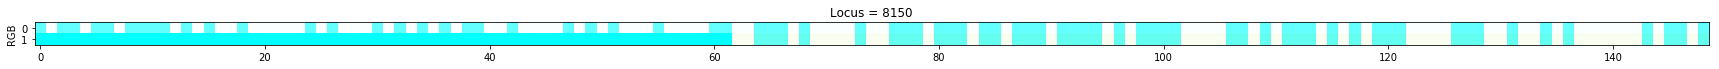

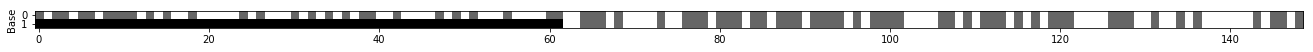

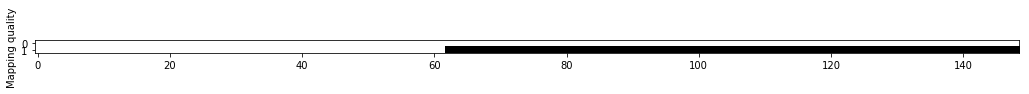

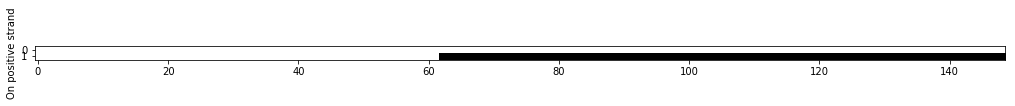

In [20]:
x = unserialized_data['scaffold161|size1025551|543642 to 552805']
visualization_locus(8150, x)

In [56]:
with open("termite_g2_scaffold_image_dict_1000K_1030K_fragment.pickle", "rb") as handle:
    unserialized_data = pickle.load(handle)

In [57]:
plot_RGB = unserialized_data['scaffold161|size1025551|543642 to 552805']

In [58]:
plot_RGB.shape

(9164, 2, 65)

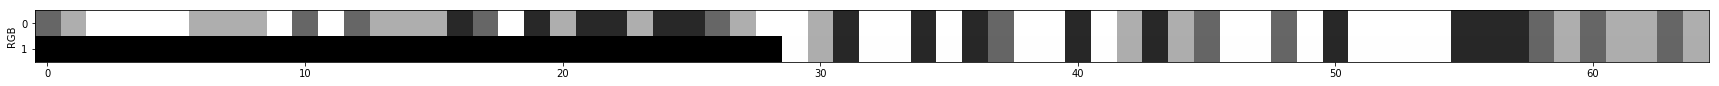

In [84]:
plt.figure(figsize=(30,5))
plt.subplot(4,1,1)
plt.imshow(plot_RGB[1002,:,:],cmap='gray')
#plt.title("Locus = %s" %locus)
plt.ylabel("RGB")
plt.show()

In [19]:
with open("termite_g2_scaffold_image_dict_scaffold53|size5504188_fragment.pickle", "rb") as handle:
    unserialized_data = pickle.load(handle)

In [84]:
plot_RGB = unserialized_data["scaffold53|size5504188|4418417 to 4424761"]

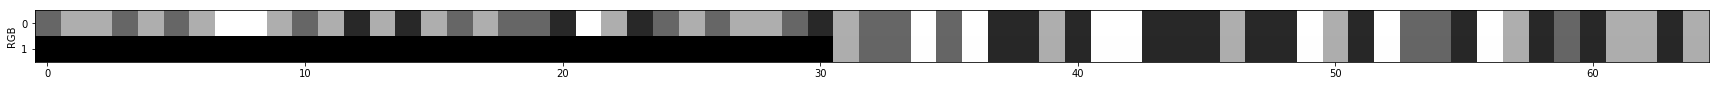

In [85]:
plt.figure(figsize=(30,5))
plt.subplot(4,1,1)
plt.imshow(plot_RGB[1000,:,:],cmap='gray')
#plt.title("Locus = %s" %locus)
plt.ylabel("RGB")
plt.show()

In [3]:
with open("termite_g2_scaffold_RANDOM_image_array_100000_17_2_10_fragment.pickle", "rb") as handle:
    random_image = pickle.load(handle)

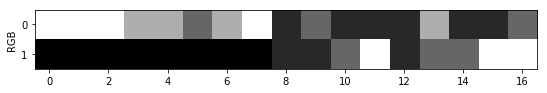

In [6]:
plt.figure(figsize=(30,5))
plt.subplot(4,1,1)
plt.imshow(random_image[1000,:,:],cmap='gray')
#plt.title("Locus = %s" %locus)
plt.ylabel("RGB")
plt.show()

# USE BED FILE TO MAKE IMAGE

In [30]:
a=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])

In [31]:
a[1:,:]=a[0,:]
a

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])